# [NML23] Assignment 2: Machine Learning on Graphs: Hand-crafted Features and Node Embeddings

TAs: [Jinhan Liu](https://people.epfl.ch/jinhan.liu) and [Arun Venkitaraman](https://people.epfl.ch/arun.venkitaraman)

## Students

* Team: `20`
* Students: `Hugo Fluhr`, `Nino Herve`

## Rules

> ⚠️ **Read carefully before starting**

**Deadline:** 

**Grading:**
* The integrality of Assignment 2 will be scaled to 100% and will amount to 25% of the overall assignments score.
* The total number of points is **40**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Anything outside shall not be touched, except if otherwise stated.

Theoretical questions shall be answered in the following markdown cell. The first line will be 
> **Your answer here:**

**Submission:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored

* You cannot import any other library than we imported.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTeX-equations

## Objective

The purpose of this assignment is to explore the usefulness of hand-crafted features and learned features with node2vec in a supervised learning setting applied to the tasks of **node-labelling** and **link-prediction**.

The dataset we will use for this assignment is the American Football dataset, that contains network of American football games between Division IA colleges during regular season Fall 2000. Vertices/nodes in the graph represent teams (identified by their college names) and edges represent regular-season games between the two teams they connect.
(https://networks.skewed.de/net/football#fnref:icon)

In [1]:
# Download the package we will use

from IPython.display import clear_output 
clear_output()

In [2]:
# Download the node2vec package we will use
# Run this cell to kill the current runtime after downloading 'node2vec', so a package version conflict about 'gensim' when using 'node2vec' can be avoided
# Run all again after commenting out this cell completely
#import os
#from IPython.display import clear_output 
#!pip install node2vec
#clear_output()
#os.kill(os.getpid(), 9) 

In [3]:
from node2vec import Node2Vec
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
%env PYTHONHASHSEED=0
import numpy as np
import pandas as pd
from IPython.display import clear_output 
clear_output()

First of all, we can download the dataset and retrieve the characteristics of the network in the following cells.

In [4]:
# Download the graph dataset named 'football.gml'
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1wVZoiTcB82N1Aoe7m1McmSK3QMM2LJ9D' -O football.gml
clear_output()

In [5]:
# Read the graph dataset
G = nx.read_gml('football.gml')

# Print the number of nodes and edges within the dataset
number_of_nodes = G.number_of_nodes()
print('Number of nodes: {}' .format(number_of_nodes))
number_of_edges = G.number_of_edges()
print('Number of edges: {}' .format(number_of_edges))

# Retrieve the labels of nodes in the dataset
values = nx.get_node_attributes(G, "value")
labels = np.unique([values[node] for node in G.nodes()])
print('The node labels are: {}' .format(labels))

Number of nodes: 115
Number of edges: 613
The node labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [6]:
# Load the nodes with each label into a set of node lists
node_list = {}
node_list = [[n for n, v in values.items() if v == l] for l in labels]

# Load the edges between nodes with same/different labels into lists
edge_list_same = [[(s, d) for (s, d) in G.edges() if s in node_list[l] and d in node_list[l]] for l in labels]
edge_list_same_all = []
for l in labels:  
  edge_list_same_all += edge_list_same[l]
edge_list_diff = [(s, d) for (s, d) in G.edges() if (s, d) not in edge_list_same_all]

# Show the nodes within each class, or teams within each league
print('The teams in each league are:')
for l in labels: print(node_list[l])

The teams in each league are:
['FloridaState', 'NorthCarolinaState', 'Virginia', 'GeorgiaTech', 'Duke', 'NorthCarolina', 'Clemson', 'WakeForest', 'Maryland']
['VirginiaTech', 'BostonCollege', 'WestVirginia', 'Syracuse', 'Pittsburgh', 'Temple', 'Rutgers', 'MiamiFlorida']
['Iowa', 'PennState', 'Northwestern', 'Wisconsin', 'Michigan', 'Purdue', 'OhioState', 'Minnesota', 'Illinois', 'MichiganState', 'Indiana']
['KansasState', 'TexasTech', 'Baylor', 'Colorado', 'Kansas', 'IowaState', 'Nebraska', 'TexasA&M', 'Oklahoma', 'Texas', 'Missouri', 'OklahomaState']
['EastCarolina', 'Houston', 'Louisville', 'Memphis', 'SouthernMississippi', 'Tulane', 'Army', 'Cincinnati', 'TexasChristian', 'AlabamaBirmingham']
['CentralFlorida', 'Connecticut', 'Navy', 'NotreDame', 'UtahState']
['NorthernIllinois', 'WesternMichigan', 'Akron', 'BallState', 'BowlingGreenState', 'Buffalo', 'CentralMichigan', 'EasternMichigan', 'Kent', 'MiamiOhio', 'Ohio', 'Toledo', 'Marshall']
['BrighamYoung', 'NewMexico', 'SanDiegoState

Now let's visualize dataset, i.e., the graph connectivity of the nodes, and the node labels. 

/usr/local/lib/python3.9/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


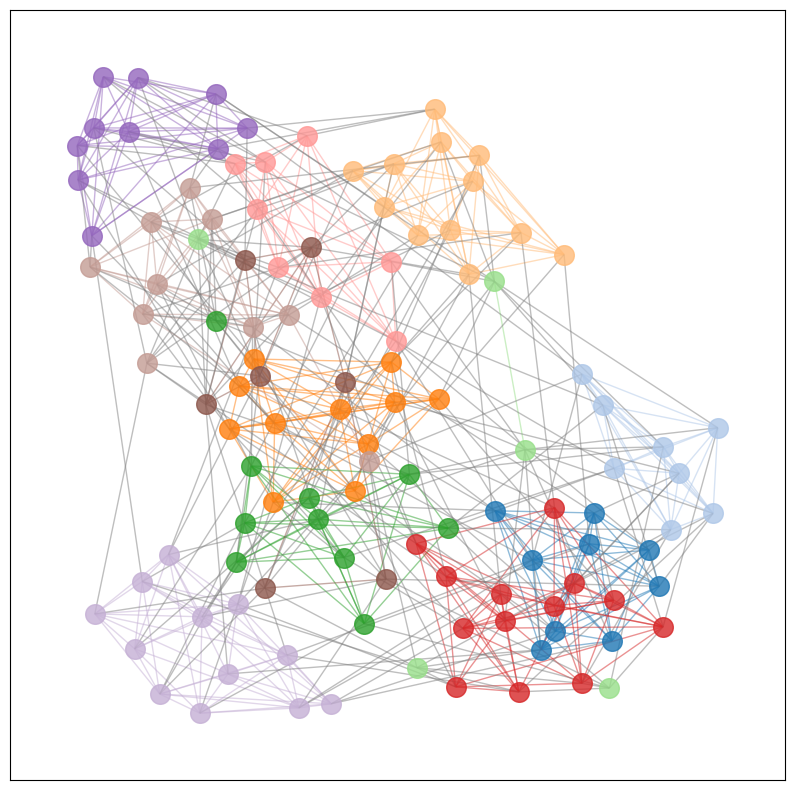

In [7]:
# Visualize the graph structure; nodes and edges within different classes are in different colors
cm = plt.cm.tab20
pos = nx.spring_layout(G, seed=0)
plt.figure(figsize=(10,10)) 

for l in labels:
  nx.draw_networkx_nodes(G, pos, nodelist= node_list[l], node_color=cm(l), node_size=200, alpha=0.8)
  nx.draw_networkx_edges(G, pos, edgelist = edge_list_same[l], width=1.0, alpha=0.5, edge_color=cm(l))
nx.draw_networkx_edges(G, pos, edgelist = edge_list_diff, width=1.0, alpha=0.5, edge_color="tab:gray")

# **Part A: Node Classification [27 pts]**



In this section, you will perform a node-labelling or classification task. You will do this in two different settings:

(a) Using traditional features of degree, eigenvector centrality,
  betweenness centrality,
  closeness centrality, and the 
  clustering_coefficients, to train a an SVM classifier

(b)  Using node2vec features to train a an SVM classifier

You can use the sklearn library for this task.


## **Question 1: On choice of node features [4pts]**

(a) Can you think of 5 hand-crafted node features (discussed in the theory lectures) that would be the most helpful to the task of node prediction for this dataset? Please motivate your choice in few sentences.

(b) Between the hand-crafted features and node2vec features, which do you think would be better predictors? Please motivate your answer.


**Your answer here:**

(a) Teams in the same league might have similar influences in the network; for example, they might play the same number of matches. We can measure the team's influence through its degree or centralities (betweenness, closeness, eigenvector). Moreover, teams from the same league play a lot with each other resulting in clusters, so measuring clustering coefficients would be another option. We implemented the five hand-crafted node features: degree, betweenness/closeness/eigenvector centrality and clustering coefficient.

(b) The hand-crafted methods only consider the node specific features or the structure of adjacent neighbours (for eigenvector centrality and clustering coefficient) but lose the information of the graph structure. In contrast, Node2Vec tries to preserve the graph structure, which seems more helpful in detecting entire communities going beyond adjacent neighbours.  

## **Question 2: Data Extraction [3 pts]** 


### 2.1  Node Feature Extraction [2 pts]
Extract the 5 traditional/hand-crafted features you chose in the earlier question and form a 5-dimensional feature vector for every node in the following cell. 

In [8]:
def node_feature_extraction(G):
  '''
  INPUT:
  G: the graph

  OUTPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
  '''
# Your solution here ###########################################################

  degrees = [G.degree(n) for n in G.nodes]
  ccs = [nx.clustering(G).get(n) for n in G.nodes]
  beetweenness_cent = [nx.betweenness_centrality(G).get(n) for n in G.nodes]
  eigenvec_cent = [nx.eigenvector_centrality(G).get(n) for n in G.nodes]
  closeness_cent = [nx.closeness_centrality(G).get(n) for n in G.nodes]

  features = np.transpose(np.array([np.array(degrees), np.array(ccs), np.array(closeness_cent), np.array(eigenvec_cent), np.array(beetweenness_cent)]))

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return features

### 2.2  Node Target and Label Extraction [1 pts]
Extract the node targets and all their possible labels in the following cell. 

In [9]:
def node_target_extraction(G):
  '''
  INPUT:
  G: the graph

  OUTPUT:
  targets: target vector of dimensions (N, ) (N: number of samples)
  labels: vector of all possible labels for nodes in the graph 
  '''
# Your solution here ###########################################################

  values = nx.get_node_attributes(G, "value")
  targets = [values[node] for node in G.nodes()]
  labels = np.unique(targets)
  
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return targets, labels

Let's implement and test your feature and target extraction modules in the cell below.

In [10]:
features_node = node_feature_extraction(G)
targets_node, labels_node = node_target_extraction(G)

## **Question 3: Classification Module [5 pts]:**

Design a classifier function by integrating modules including:

1. **Data spliting**: Split dataset into train and test sets (50% - 50%). Make sure the data partition is stratified.

2. **Feature selection**: Implement a feature selection preprocessing step before training to use the k highest scored features for the classification task. You might find `SelectKBest` and `f_classif` in `sklearn.feature_selection` helpful.

3. **Normalization**: Normalize the features after feature selection and before training.

4. **Support-vector based classifier**. You might find `svm.SVC` helpful. Please set `class_weight='balanced'`.

5. **Evaluation**: Implement prediction on the test set. Show the performance using weighted f1 score, and display the confusion matrix. You might find `sklearn.metrics.ConfusionMatrixDisplay` helpful.

*** Please set all `random_state=0` and `seed=0` for reproducibility.**

** This function will be used both for node classification and link prediction in the following parts.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

def classifier(features, targets, labels, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=False):
  ''' 
  INPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features) 
  targets: target vector of dimensions (N, ) (N: number of samples)
  labels: vector of all possible labels for nodes in the graph 
  feature_selection: a flag for whether to use feature selction, bool
  num_features: number of features used from feature selesction
  test_size: please set to 0.5 for reproducibility
  seed: please set to 0 for reproducibility
  verbose: print and plot result or not, bool
  
  OUTPUT:
  cm: confusion matrix on the test set
  f1: weighted f1 score on the test set

  ** Please set all of the random_state=seed in following module **
  '''

  # Split the data into training and testing sets, with test_size=0.5
  # Your solution here ###########################################################

  X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_size, random_state=seed, stratify=targets)

  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  if feature_selection:
    ## Your solution here ###########################################################
    ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification. 
    
    feat_select = SelectKBest(f_classif, k=num_features).fit(X_train, y_train)
    X_train_kfeat = feat_select.transform(X_train)
    X_test_kfeat = feat_select.transform(X_test)

    # create the scaler and fit it to train data
    scaler = StandardScaler()
    scaler.fit(X_train_kfeat)

    # create model
    model = svm.SVC(class_weight='balanced')

    # train model
    model.fit(scaler.transform(X_train_kfeat), y_train)

    # predict test set
    predictions = model.predict(scaler.transform(X_test_kfeat))
    
    ## Print the scores for individual features.
    if verbose :
      print("Scores of the features : \n {} \n".format(["%.3f" % s for s in feat_select.scores_]))

    ##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  else:
    ## Your solution here ###########################################################
    ## Build and train the ML model, including normalization and Support Vector Classifier.

    # create the scaler and fit it to train data
    scaler = StandardScaler()
    scaler.fit(X_train)

    # create model
    model = svm.SVC(class_weight='balanced')

    # train model
    model.fit(scaler.transform(X_train), y_train)

    # predict for test set
    predictions = model.predict(scaler.transform(X_test))

    ##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  # Your solution here ###########################################################
  # Use the model to predict the labels of the test data

  cm = metrics.confusion_matrix(y_test, predictions, labels=labels)
  f1 = metrics.f1_score(y_test, predictions, labels=labels, average='weighted')
  
  # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose
  
  if verbose:
    print('\nf1 score: ', f1)

    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

    if len(labels) == 2:
      fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
      roc_auc = metrics.auc(fpr, tpr)
      print('\nROC AUC score: ', roc_auc)

  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return cm, f1

## **Question 4: Node Classification Using Handcrafted Features [4 pts]:**

### 4.1  Node Classification without Feature Selection [2 pt]

Train the classifier without feature selection (using all the 5 features) and show the output.


f1 score:  0.34849920194747774


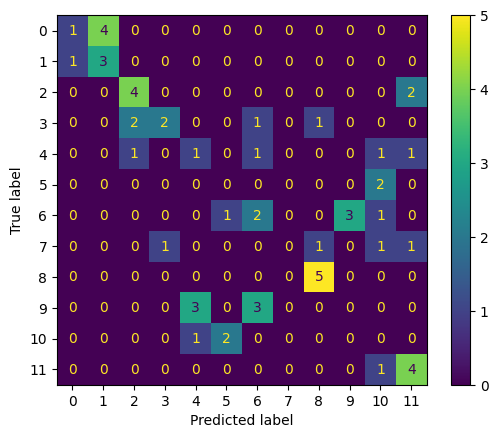

In [12]:
# Your solution here ###########################################################

cm, f1 = classifier(features_node, targets_node, labels, feature_selection=False, verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Then train the classifier with feature selection with top 3 features and show the output including the feature scores.

Scores of the features : 
 ['5.639', '5.225', '3.002', '16.056', '1.022'] 


f1 score:  0.45379098870478174


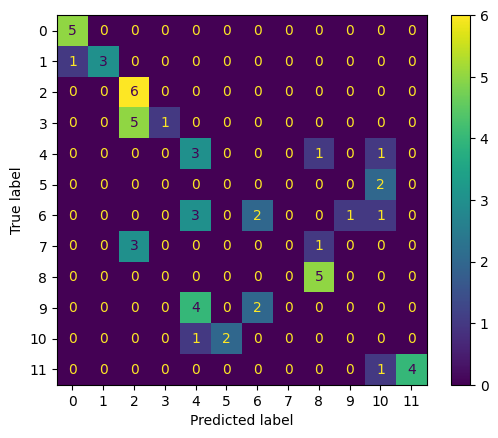

In [13]:
# Your solution here ###########################################################

cm, f1 = classifier(features_node, targets_node, labels, feature_selection=True, num_features = 3,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### 4.2  Find the best number of features selected [1 pt]
With respect to the weighted f1 score, which is the best number of K chosen for the classification performance on the test set? Show the results using different K into a plot and find the best number of K.

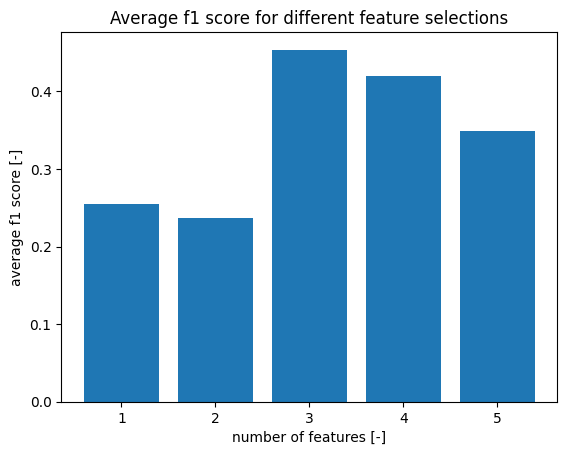

The best K with respect to weighted f1 score is: 3


In [14]:
# Plot the weighted f1 score using different number of best K features in a figure, and print out the best number of K
''' 
  k_best: the best number of K with respect to weighted f1 score on the test set
'''
# Your solution here ###########################################################

ks = np.arange(1,features_node.shape[1]+1)
f1_scores = []

for k in ks:

  _, f1 = classifier(features_node, targets_node, labels_node, feature_selection=True, num_features=k);
  f1_scores.append(f1)

k_best = ks[np.argmax(f1_scores)]

plt.bar(ks, f1_scores)
plt.xlabel('number of features [-]')
plt.ylabel('average f1 score [-]')
plt.title('Average f1 score for different feature selections')
plt.show()

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print("The best K with respect to weighted f1 score is: {}".format(k_best))

### 4.3  Explanations for the Best Features [1 pt]
What are the best top K features selected in your implementation? Could you please give an possible explanation for why they play important roles in our node classification task? 

**Your answer here:** 

The best k-features in our implementation are the eigenvector centrality (score = 16), the degree (score = 5.6) and the clustering coefficient (score = 5.2). They are the three features that measure their importance relative to their adjacent neighbours. Consequently, the neighbourhood of a node might be valuable information for this classification task. 

## **Question 5: Node2vec features [11 pts]**

### 5.1  Node2Vec Basics [1 pt]

Explain the main components of the Node2vec embedding and discuss in short the relevance of the parameters walk length, p, and q, used in the embedding.



**Your answer here:** 

The Node2Vec embedding captures each node's probability of reaching another node with a fixed-length random walk. If the length of the walk is small, a starting node might never reach another ending node, and the probability will be assumed to be 0. If the walk was longer, the same probability might have been different. Additionally, the parameters p and q influence the random walk strategy. While p controls the likelihood of immediately revisiting a node,  q controls how fast the walk explores new nodes. This last part is the main strenght of the algorithm, by selectively biasing the random walk, one can chose whether the focus is put on structural or homophiliy aspects.

### 5.2 About node2vec parameters [3p]

As you know node2vec has two parameters p and q.
Which configuration of these parameters do you think best suits this task?
low/low, low/high, high/low, or high/high?

Please motivate your answer.


**Your answer here:** 

The parameter p controls the likelihood of immediately revisiting a node in the walk. Higher values of p ensure a lower probability of revisiting. The parameter q controls the probability of visiting a node close to the previous node (high q) or far from the previous node (low q). Therefore, a low p and high q restrain the random walks to explore locally, a.k.a Breadth-first search (BFS), while a high p and low q favor far explorations, a.k.a Depth-first search (DFS). Other combinations of p and q will result in a search strategy between BFS and DFS. According to the course, BFS is better for capturing structural nodes, and DFS is better for capturing communities. Assuming leagues behave like communities, a DFS strategy should be more favorable for our classification task.


### 5.3  Node2Vec Node Feature Extraction [1 pt]

Extract the node2vec features of nodes using the `node2vec.Node2Vec`.

*** Please set `random_state=0` and `seed=0` for reproducibility.**




In [15]:
def Node2Vec_node_feature_extraction(G, num_features=1, p=1.0, q=1.0, seed=0):
  ''' 
  INPUT:
  G: the graph
  num_features: dimension of node2vec embeddings, int
  p: float
  q: float
  seed: please always set to 0
  
  OUTPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings) 
  '''
  
  # 
  # Your solution here ###########################################################

  # Precompute probabilities and generate walks
  node2vec = Node2Vec(G, dimensions=num_features,p=p, q=q, seed=seed, quiet=True)

  # Embed nodes
  model = node2vec.fit()

  # get vectors
  features = np.array([model.wv.get_vector(str(n)) for n in G.nodes()])

  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return features

### 5.4  Implement node classification using Node2Vec [2 pts]
Let's implement your Node2Vec based classification by setting `num_features=3, p=1.0, q=0.1`


f1 score:  0.5561092164540441


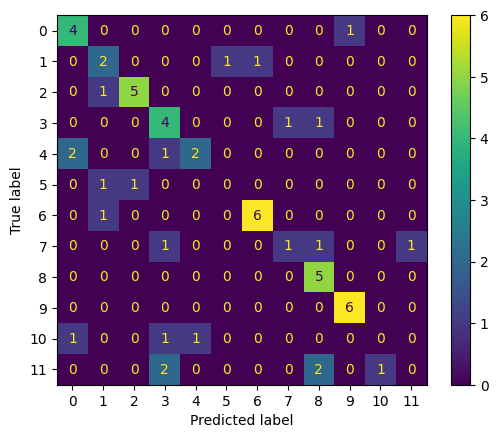

In [16]:
# Implement Node2Vec by setting: 
# num_features=3, p=1.0, q=0.1
# Your solution here ###########################################################

n2v_features = Node2Vec_node_feature_extraction(G, num_features=3, p=1., q=0.1)
cm, f1 = classifier(n2v_features, targets_node, labels, feature_selection=False,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Let's change your parameters to `q=10.0` and implement your results.


f1 score:  0.8486169003410382


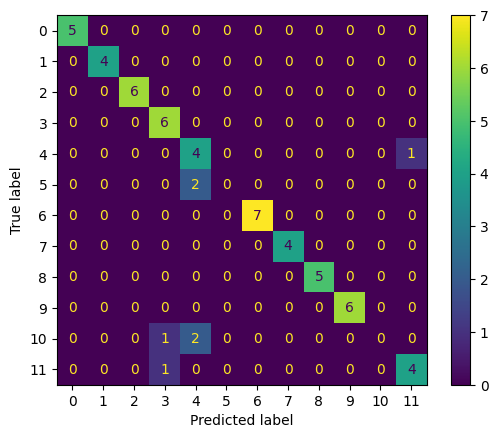

In [17]:
# Implement Node2Vec by changing: 
# q=10.0
# Your solution here ###########################################################

n2v_features = Node2Vec_node_feature_extraction(G, num_features=3, p=1., q=10.)
cm, f1 = classifier(n2v_features, targets_node, labels, feature_selection=False,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### 5.5  Parameters in Node2Vec [2 pts]

What difference do you observe in both classifiers? Why do you think this difference exists by changing this parameter?

**Your answer here:**  
 
The combination low/high has fewer misclassifications and a better f1 score than low/low. This difference could mean the classes are better separated by their node's structural role than their communities. 

What might be other parameters that we can change in Node2Vec to improve our classification performance? Try to change this parameter and implement in the cell below to achieve a better performance than above.

**Your answer here:** 

Another parameter we can play with is the number of features we consider for the embedding space. More features might capture more valuable information to increase performance.


f1 score:  0.901751505199781


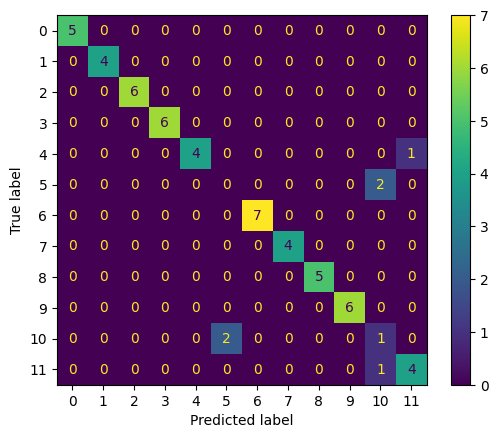

In [18]:
# Implement Node2Vec by changing your chosen parameter and try to achieve a better performance
# Your solution here ###########################################################

n2v_features = Node2Vec_node_feature_extraction(G, num_features=5, p=1., q=10.)
cm, f1 = classifier(n2v_features, targets_node, labels, feature_selection=False,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### 5.6  Comparing Hand-crafted and Node2Vec Features [2 pts]

Now we can combine the hand-crafted features and node2vec embeddings together. Use the 5 hand-crafted features and 5-dimensional node embeddings. Construct them into 10-dimensional features and implement them into the classifier with top-3 scored features and show the feature scores in the following cell.

*** Please set `seed=0`, `p=1.0` and `q=10.0` for reproducibility.**

Scores of the features : 
 ['5.639', '5.225', '3.002', '16.056', '1.022', '32.875', '35.886', '27.357', '37.286', '43.273'] 


f1 score:  0.8636015325670499


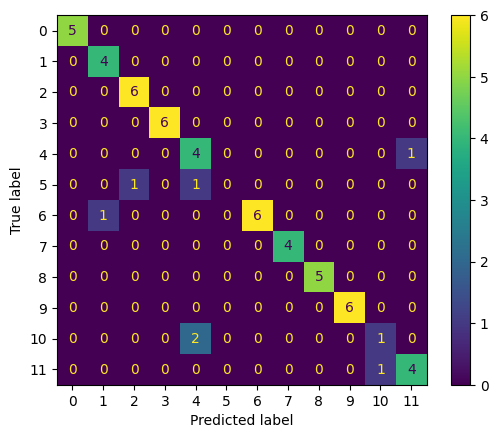

In [19]:
# Implement Node2Vec and combine them with hand-crafted features then use them for classification
# Your solution here ###########################################################

n2v_features = Node2Vec_node_feature_extraction(G, num_features=5, p=1., q=10.)
combined_features = np.hstack([features_node, n2v_features])
cm, f1 = classifier(combined_features, targets_node, labels, feature_selection=True, num_features = 3,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

According the results you showed above, which group of features between hand-crafted and Node2Vec are scored better in general? Could you give an explanation for why this group of features are scored higher than the others and are better predictors in the classifier?

**Your answer here:** 

Node2Vec's features scored better in general. Since Node2Vec preserves the initial structure of the graph, it can be used for neighborhood-based applications. As we saw in question 4.3, a node's neighborhood seems valuable information for this classification task, which could explain Node2Vec's higher performance.

# **Part B: Link Prediction [13 pts]**



In this section, you will perform a link prediction task: We will predict whether or not a link exists between two pairs of nodes, with the entries of the adjancency matrix being the link values to predict (0 or 1). We will consider both handcrafted and node2vec features to train an SVM classifier.

As before you can use the sklearn library for this task.


## **Question 6: Data Extraction [4 pts]**


### 6.1  Operators on Node Features [2 pts]

In absence of specific edge features, a typical approach is to use an operator to combine the node features corresponding to a given edge to form a combined edge feature. That is to arrive at features $f_{ij}$, node features $f_i$ and $f_j$ are used together.

In addition to the `average_operator` below, you should come up with three more different ways of doing this. Each of the proposed ways should be implemented in the cell below.

**You answer here:**

Since edges in our graph are undirected (if team A plays against team B, then team B plays against team A), the operators should be commutative. Here are three commutative operators:
- product: $x\times y$
- absolute difference: $|x-y|$
- l2 norm: $||(x,y)||_2$

In [20]:
def average_operator(x, y):
  ''' 
  INPUT:
  x, y: pair of node features, each with dimension (D, ) (D: dimension of features) 
  
  OUTPUT:
  edge features by the operation on node features, with dimension (D, )
  '''
  return (x + y) / 2

# Your solution here ###########################################################

def multiply_operator(x, y):
  ''' 
  INPUT:
  x, y: pair of node features, each with dimension (D, ) (D: dimension of features) 
  
  OUTPUT:
  edge features by the operation on node features, with dimension (D, )
  '''
  
  return np.multiply(x,y)

def difference_operator(x, y):
  ''' 
  INPUT:
  x, y: pair of node features, each with dimension (D, ) (D: dimension of features) 
  
  OUTPUT:
  edge features by the operation on node features, with dimension (D, )
  '''
  return np.abs(x-y)

def l2_operator(x, y):
  ''' 
  INPUT:
  x, y: pair of node features, each with dimension (D, ) (D: dimension of features) 
  
  OUTPUT:
  edge features by the operation on node features, with dimension (D, )
  '''
  xy = np.stack([x,y], axis=1)
  return np.linalg.norm(xy, ord=2, axis=1)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

### 6.2  Edge Feature, Target and Label Extraction [2 pts]

Write a code for

(a) Extracting the edge features

(b) extracting the edge target s

In [21]:
def edge_feature_extraction(features_node, operator):
  ''' 
  INPUT:
  features_node: node feature matrix of dimensions (N, D) (N: number of samples; D: dimension of features) 
  operator: operator computing pair of node features, function defined above
  
  OUTPUT:
  features_edge: edge feature matrix of dimensions (N, D) (N: number of samples; D: dimension of features) 
  '''
  # 
  # Your solution here ###########################################################

  n_nodes = features_node.shape[0]
  features_edge = []

  for i in range(n_nodes-1):
    for j in range(i+1, n_nodes):
      features_edge.append(operator(features_node[i], features_node[j]))

  features_edge = np.array(features_edge)

  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return features_edge

In [22]:
def edge_target_extraction(G):
  ''' 
  INPUT:
  G: the graph
  
  OUTPUT:
  targets: target vector of dimensions (N, ) (N: number of samples), with values of {0, 1}
  labels: vector of all possible labels for nodes in the graph 
  '''
  # 
  # Your solution here ###########################################################

  A = nx.adjacency_matrix(G)
  targets = A[np.triu_indices(A.shape[0], k=1)]
  targets = np.array(targets).squeeze()

  labels = np.unique(targets)
  
  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return targets, labels

Let's implement and test your feature and target extraction modules in the cell below. 

*** You can implement the following section using the operator you prefer, while please use the same operator for both hand-crafted and Node2Vec features in the following section.**

In [23]:
# Extract your edge-level features, targets and labels. You can replace `average_operator` with others.
features_edge = edge_feature_extraction(features_node, l2_operator)
targets_edge, labels_edge = edge_target_extraction(G)
clear_output()

## **Question 7: Link prediction Implementions [9 pts]**

### 7.1  Link Prediction Implementation [5 pts]

Use the method of choice to compute edge-features for the given dataset. Then, train a link predictor, compute the confusion matrix and weighted f1 and ROC AUC scores as before. As before repeat the experiment for the case of node2vec parameter set to values 1 and 10. You may use the itertools library to help you with the feature fusion.

First let's train the classifier based on handcrafted node features without feature selection (using all the 5 features) and show the output.


f1 score:  0.7641251184770057


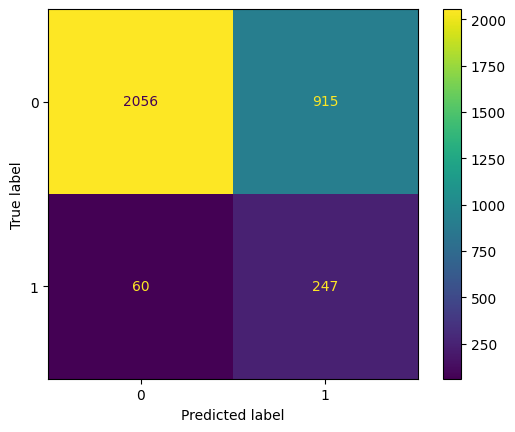


ROC AUC score:  0.7482915742514228


In [24]:
# Your solution here ###########################################################

operator = difference_operator

features_edge = edge_feature_extraction(features_node, operator)

classifier(features_edge, targets_edge, labels_edge, verbose=True);

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Then let's train the classifier based on handcrafted node features with feature selection and show the output.

Scores of the features : 
 ['1.638', '39.002', '14.820', '158.404', '0.059'] 


f1 score:  0.7635950679274844


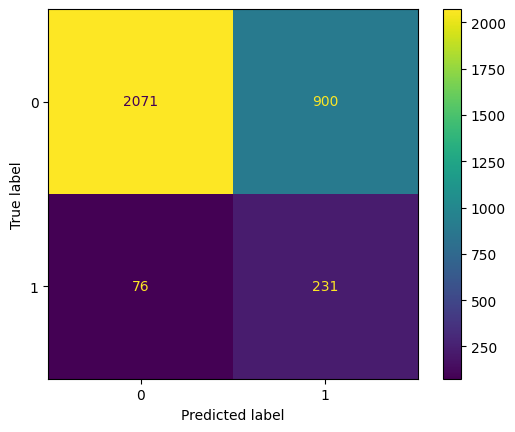


ROC AUC score:  0.72475734488766


In [25]:
# Your solution here ###########################################################

f1, cm = classifier(features_edge, targets_edge, labels_edge, feature_selection=True, num_features=3, verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


f1 score:  0.7993311206701363


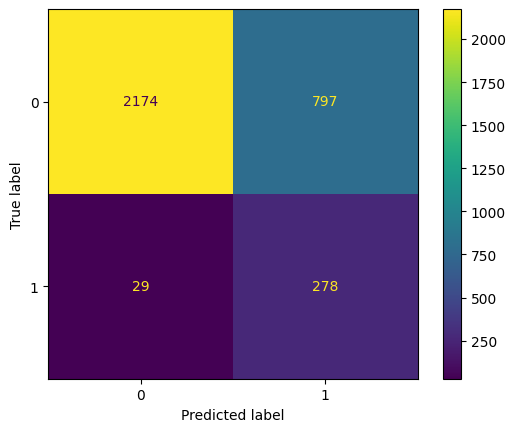


ROC AUC score:  0.8186388070567056


In [26]:
# Your solution here ###########################################################

n2v_features = Node2Vec_node_feature_extraction(G, num_features=3, p=1., q=0.1)
features_edge = edge_feature_extraction(n2v_features, operator)

cm, f1 = classifier(features_edge, targets_edge, labels_edge, feature_selection=False,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Train the classifier based on Node2Vec features change the parameter to `q=10.0` and show the output.


f1 score:  0.906058760412548


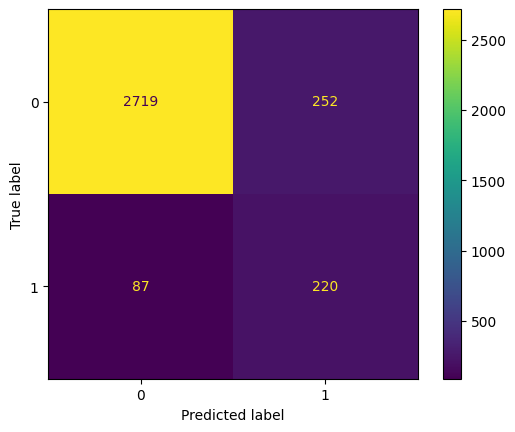


ROC AUC score:  0.8158962259496522


In [27]:
# Your solution here ###########################################################

n2v_features = Node2Vec_node_feature_extraction(G, num_features=3, p=1., q=10)
features_edge = edge_feature_extraction(n2v_features, operator)

cm, f1 = classifier(features_edge, targets_edge, labels_edge, feature_selection=False,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Implement the same change of parameter you chose as it is in **Question 4.4** and show the output.


f1 score:  0.9259921373116597


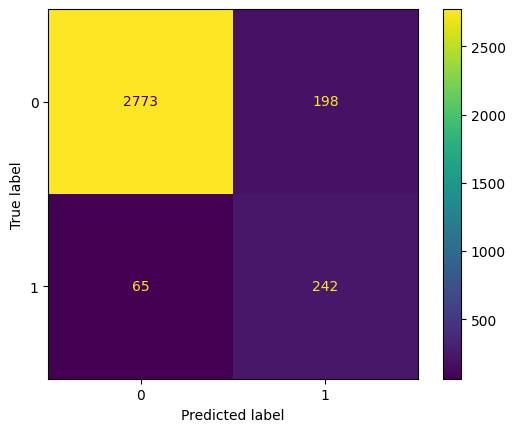


ROC AUC score:  0.8608146940511809


In [28]:
# Your solution here ###########################################################

n2v_features = Node2Vec_node_feature_extraction(G, num_features=5, p=1., q=10)
features_edge = edge_feature_extraction(n2v_features, operator)

cm, f1 = classifier(features_edge, targets_edge, labels_edge, feature_selection=False,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Similar with **Question 4.5**, use the 5 hand-crafted features and 5-dimensional node embeddings to construct 10-dimensional features and implement them into the classifier with top-3 scored features and show the feature scores in the following cell.

*** Please set `seed=0`, `p=1.0` and `q=10.0` for reproducibility.**

Scores of the features : 
 ['1.638', '39.002', '14.820', '158.404', '0.059', '219.971', '322.812', '229.990', '201.379', '308.203'] 


f1 score:  0.927021737840026


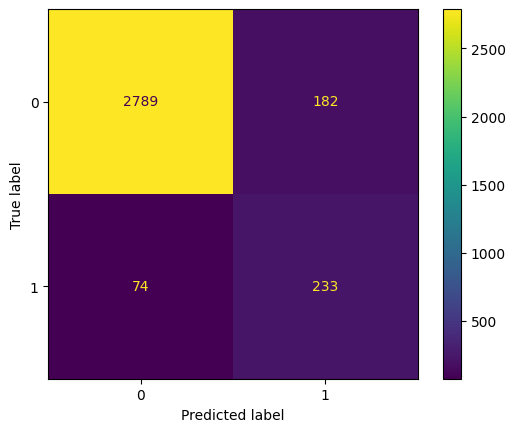


ROC AUC score:  0.8488494096570869


In [29]:
# Implement Node2Vec and combine them with hand-crafted features then use them for classification
# Your solution here ###########################################################

n2v_features = Node2Vec_node_feature_extraction(G, num_features=5, p=1., q=10)
combined_features = np.hstack([features_node, n2v_features])
features_edge = edge_feature_extraction(combined_features, operator)

cm, f1 = classifier(features_edge, targets_edge, labels_edge, feature_selection=True, num_features=3,verbose=True)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

According the results you showed above, which group of features between hand-crafted and Node2Vec are scored better in general? Could you give an explanation for why this group of features are scored higher than the others and are better predictors in the classifier?

**Your answer here:** 

Node2Vec's features scored better in general. Since Node2Vec keeps the similarity between nodes, the classifier can use that information to link similar nodes between each other. Handcrafted features do not preserve that information and can only link nodes with similar node features like degree and centrality.

### 7.2  Link Prediction Observations [4 pt]

Based on your observations on the implementations, among the implementations above using a single group of either hand-crafted and Node2Vec features, which one achieves better performance in general? How do the parameters in Node2Vec influence the classfication performance. 

By combining these features together, which group is scored higher during feature selection? Do and how do the operators on the node-level features influence the classification performance?

**Your answer here**  
 
The best performance is obtained when using only the Node2Vec features. The best parameters for Node2Vec are the same as the one that maximized node classification performance; it seems that this parameters choice is well suited to capture relevant characteristics of this graph.

Combining the features does not improve performance when feature selection is used at it results in just using the top 3 Node2Vec features. The choice of node-level feature combination operator to create edge features does influence the performance. From our experience, the absolute difference operator lead to the best results.